In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate

# Stored variables not reading back in properly, marking out for now and re-training the X and y below.
#%store -r X
#%store -r y
#%store -r X_train
#%store -r X_test
#%store -r y_train
#%store -r y_test

In [20]:
df_mod = pd.read_csv(f'/Users/ryanm/Desktop/df-mod.csv')
print(df_mod.shape)
df_mod.head(5)

(3214874, 14)


,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,product_name_code,aisle_code,department_code
0,1,1,2539329,3,9,12.0,26405,5,0,54,17,31683,99,11
1,1,2,2398795,4,8,16.0,26088,6,1,23,19,980,103,20
2,1,3,473747,4,13,22.0,30450,5,1,88,13,7124,124,16
3,1,4,2254736,5,8,30.0,26405,5,1,54,17,31683,99,11
4,1,5,431534,5,16,29.0,41787,8,1,24,4,2419,50,19


In [21]:
X = df_mod.drop('reordered', axis = 1)
y = df_mod['reordered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# First let's start with a Logistic Regression model so we have a good basis on what our data is telling us.
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

# Establish metrics for the model.
lr_acc = accuracy_score(y_test, lr_y_pred)
lr_conf_matrix = confusion_matrix(y_test, lr_y_pred)
lr_cls_report = classification_report(y_test, lr_y_pred)

print("Metrics for Logistic Regression Model")
print("Accuracy: ", lr_acc)
print("Confusion Matrix: ", lr_conf_matrix)
print(lr_cls_report)

Metrics for Logistic Regression Model
Accuracy:  0.879387223453478
Confusion Matrix:  [[     0  77551]
 [     0 565424]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     77551
           1       0.88      1.00      0.94    565424

    accuracy                           0.88    642975
   macro avg       0.44      0.50      0.47    642975
weighted avg       0.77      0.88      0.82    642975



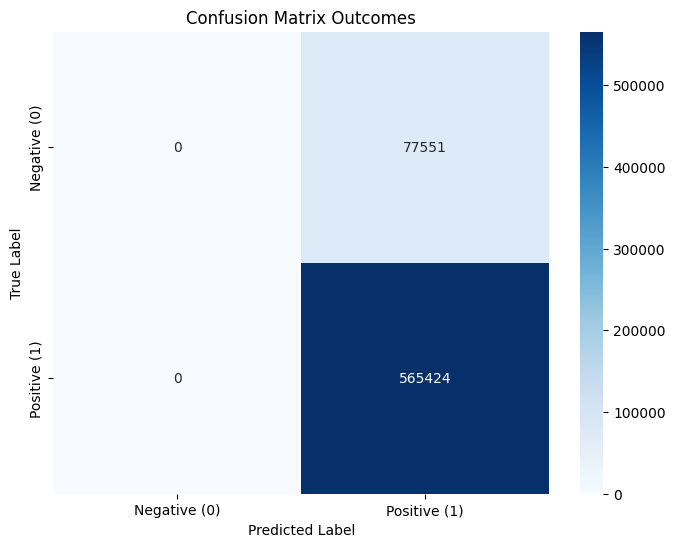

In [13]:
# Good start, but lots of imbalancing.  Let's plot to get a better look.
plt.figure(figsize = (8,6))
sns.heatmap(lr_conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Negative (0)', 'Positive (1)'], yticklabels = ['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Outcomes')
plt.show()

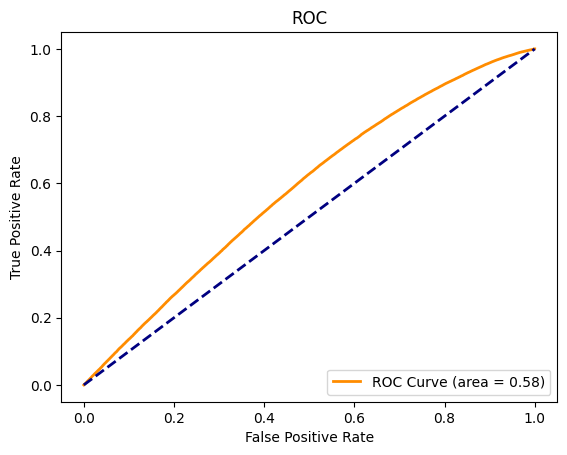

In [16]:
# Let's look at a ROC Curve now
probs = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
lr_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC Curve (area = %0.2f)' % lr_roc_auc)
plt.plot([0,1], [0,1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc = 'lower right')
plt.show()

In [23]:
# Note the best score for the ROC, let's continue with a SVD model and then model stack.
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(df_mod[['user_id', 'product_name_code', 'reordered']], reader)

svd = SVD()
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(results)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3351  0.3357  0.3360  0.3347  0.3353  0.3354  0.0005  
MAE (testset)     0.2520  0.2534  0.2535  0.2516  0.2530  0.2527  0.0007  
Fit time          29.07   30.05   30.08   30.01   31.18   30.08   0.67    
Test time         4.96    5.05    5.65    4.88    5.51    5.21    0.31    
{'test_rmse': array([0.33505263, 0.33567173, 0.3360395 , 0.33473079, 0.33529076]), 'test_mae': array([0.25203083, 0.253426  , 0.25346933, 0.25163448, 0.25298425]), 'fit_time': (29.071895122528076, 30.046834707260132, 30.07958221435547, 30.00570845603943, 31.180312871932983), 'test_time': (4.955295562744141, 5.047842741012573, 5.645554780960083, 4.87533712387085, 5.513058662414551)}
